In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import C3XGate, CPhaseGate
from fractions import Fraction
from math import gcd
import pandas as pd
import numpy
import matplotlib

In [34]:
def alice(qreq_q, creq_q):

    qc = QuantumCircuit(qreq_q, creq_q) #initiate circuit
    qc.h(qreq_q[0])                     #first QFT, qubit qt1
    qc.h(qreq_q[1])                     #first QFT, qubit qt2
    qc.h(qreq_q[2])                     #first QFT, qubit qt3
    qc.x(qreq_q[-1])                    #flip the last L-qubit from default |0> to |1>
    qc.barrier()
    
    #1, 4 CCCNOTs that flip |111>|00001> into |111>|10110> (binary for 8^7mod35 = 22)
    qc.append(C3XGate(), [0,1,2,3])     
    qc.append(C3XGate(), [0,1,2,5])     #2
    qc.append(C3XGate(), [0,1,2,6])     #3
    qc.append(C3XGate(), [0,1,2,7])     #4
    #qc.barrier()
    
    #1, 3 CNOT's that flip |110>|10110> into |110>|11101> (binary for 8^6mod35 = 29)
    qc.ccx(qreg_q[0], qreg_q[1], qreg_q[4])         
    qc.ccx(qreq_q[0], qreg_q[1], qreg_q[6])
    qc.ccx(qreq_q[0], qreg_q[1], qreg_q[7])
    #qc.barrier()
    
    #1, 3 CNOT's that flip |101>|11101> into |111>|01000> (binary for 8^5mod35 = 8)
    qc.ccx(qreg_q[0], qreq_q[2], qreg_q[3])     
    qc.ccx(qreg_q[0], qreq_q[2], qreg_q[5])
    qc.ccx(qreq_q[0], qreg_q[2], qreg_q[7]) #(2)
    #qc.barrier()

    qc.cx(qreg_q[0], qreg_q[4])
    qc.cx(qreg_q[0], qreg_q[7]) #(2)
    #qc.barrier()


    qc.measure_all()
    #qc.measure(qreg_q[0], creg_q[0])
    #qc.measure(qreg_q[1], creg_q[1])
    #qc.measure(qreg_q[2], creg_q[2])
    #qc.measure(qreg_q[3], creg_q[3])
    #qc.measure(qreg_q[4], creg_q[4])
    #qc.measure(qreg_q[5], creg_q[5])
    #qc.measure(qreg_q[6], creg_q[6])
    #qc.measure(qreg_q[7], creg_q[7])

    qcA = qc

    return qcA

In [32]:
def bob(qreq_q, creq_q):

    qc = QuantumCircuit(qreq_q, creq_q)
    #1, 3 CNOT's that flip |100>|01000> into |100>|00001> (binary for 8^4mod35 = 1)

       
    #1, 3 CNOT's that flip |011>|00001> into |011>|10110> (binary for 8^3mod35 = 22)
    qc.ccx(qreg_q[1], qreq_q[2], qreg_q[3])
    qc.ccx(qreg_q[1], qreq_q[2], qreg_q[5])
    qc.ccx(qreg_q[1], qreq_q[2], qreg_q[6])
    qc.ccx(qreg_q[1], qreg_q[2], qreg_q[7])
    #qc.barrier()
    
    #1, 3 CNOT's that flip |010>|10110> into |010>|11101> (binary for 8^2mod35 = 29)
    qc.cx(qreg_q[1], qreg_q[4]) #(1)
    qc.cx(qreg_q[1], qreg_q[6])
    qc.cx(qreg_q[1], qreg_q[7])
    #qc.barrier()

    #1, 3 CNOT's that flip |001>|11101> into |001>|01000> (binary for 8^1mod35 = 8)
    qc.cx(qreg_q[2], qreg_q[3])
    qc.cx(qreg_q[2], qreg_q[5])
    qc.cx(qreg_q[2], qreq_q[7])
    qc.barrier()
    
    qc.x(qreq_q[0])                     #x=0 (|000> -> |111>) Otherwise CCCNOT will not flip target bits
    qc.x(qreq_q[1])
    qc.x(qreq_q[2])
    qc.append(C3XGate(), [0,1,2,4])     
    qc.append(C3XGate(), [0,1,2,7])
    qc.x(qreq_q[0])
    qc.x(qreq_q[1])
    qc.x(qreq_q[2])
    qc.barrier()

    qc.h(qreq_q[0])
    qc.append(CPhaseGate(90).control(0), [qreg_q[0], qreg_q[1]])
    qc.append(CPhaseGate(45).control(0), [qreq_q[0], qreq_q[2]])
    qc.h(qreq_q[1])
    qc.append(CPhaseGate(90).control(0), [qreq_q[1], qreq_q[2]])
    qc.h(qreq_q[2])
    qc.barrier()

    qc.measure(qreg_q[0], creg_q[0])
    qc.measure(qreg_q[1], creg_q[1])
    qc.measure(qreg_q[2], creg_q[2])
    qc.measure(qreg_q[3], creg_q[3])
    qc.measure(qreg_q[4], creg_q[4])
    qc.measure(qreg_q[5], creg_q[5])
    qc.measure(qreg_q[6], creg_q[6])
    qc.measure(qreg_q[7], creg_q[7])
    

    qcB = qc

    return qcB

In [9]:
def alicebob(qcA, qcB):

    circuit = qcA + qcB

    return circuit

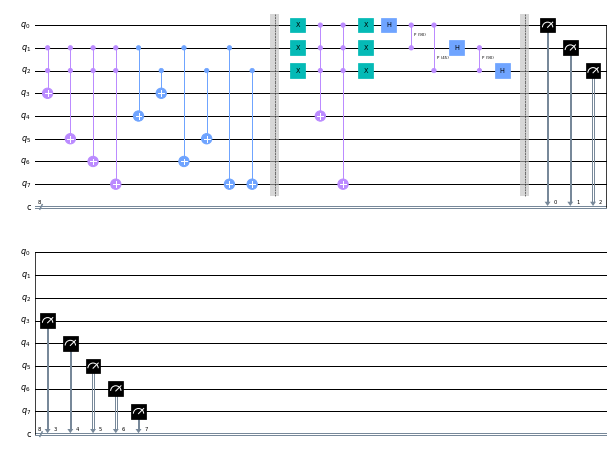

In [35]:
qreg_q = QuantumRegister(8, 'q')
creg_q = ClassicalRegister(8,'c')
qcA = alice(qreg_q, creg_q)
qcB = bob(qreg_q, creg_q)
circuit = alicebob(qcA, qcB)
qcB.draw(output='mpl', scale=0.5)


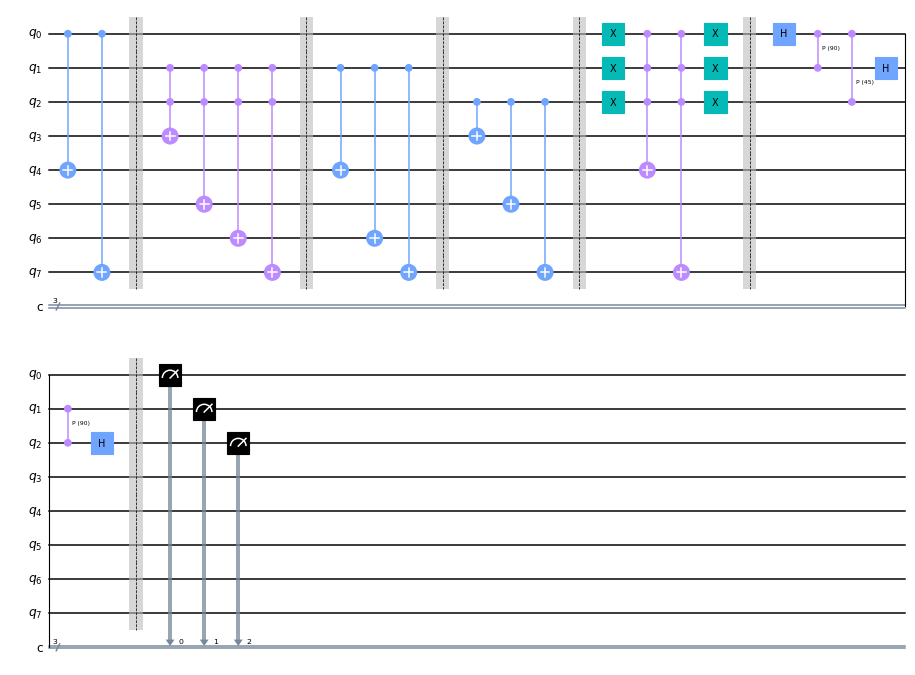

In [16]:
qcB.draw(output='mpl', scale=0.75)